In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

np.random.seed(42)
random_state = np.random.get_state()

In [2]:
# world height, width
WORLD_HEIGHT = 4
WORLD_WIDTH = 12

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [3, 0]
GOAL = [3, 11]

In [3]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False
    
    reward = -1
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10)  \
    or (action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START
    
    return next_state, reward

# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        return np.random.choice(np.argwhere(np.max(values_) == values_).flatten())

In [4]:
# an episode with Sarsa
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, step_size=ALPHA):
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0

    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward

        q_value[state[0], state[1], action] = q_value[state[0], state[1], action] + step_size * (reward + GAMMA * q_value[next_state[0], next_state[1], action])
        state = next_state
        action = next_action
    
    return rewards

# an episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA):
    state = START
    rewards = 0.0

    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward

        # Q-Learning update
        q_value[state[0], state[1], action] = q_value[state[0], state[1], action] + step_size * (reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) - q_value[state[0], state[1], action])
        
        state = next_state
    
    return rewards

# print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(WORLD_WIDTH):
            if [i, j] == GOAL:
                optimal_policy[-1].append("G")
                continue
            
            best_action = np.argmax(q_value[i, j, :])
            if best_action == ACTION_UP:
                optimal_policy[-1].append("U")
            elif best_action == ACTION_DOWN:
                optimal_policy[-1].append("D")
            elif best_action == ACTION_LEFT:
                optimal_policy[-1].append("L")
            elif best_action == ACTION_RIGHT:
                optimal_policy[-1].append("R")
    
    for row in optimal_policy:
        print(row)

In [5]:
# Use multiple runs instead of a single run and a sliding window
# With a single run I failed to present a smooth curve
# However the optimal policy converges well with a single run
# Sarsa converges to the safe path, while Q-Learning a converges to the optimal path
def figure_6_4():
    # episodes of each run
    episodes = 500

    # perform 500 independent runs
    runs = 500

    np.random.set_state(random_state)
    rewards_sarsa = np.zeros(episodes)
    for r in trange(runs):
        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
        for i in range(episodes):
            rewards_sarsa[i] += sarsa(q_sarsa)

    np.random.set_state(random_state)
    rewards_q_learning = np.zeros(episodes)
    for r in trange(runs):
        q_q_learning = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
        for i in range(episodes):
            rewards_q_learning[i] += q_learning(q_q_learning)

    # averaging over independent runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs

    # draw reward curves
    plt.plot(rewards_sarsa, label="Sarsa")
    plt.plot(rewards_q_learning, label="Q-Learning")
    plt.xlabel("Episodes")
    plt.ylabel("Sum of rewards during episode")
    plt.ylim([-100, 0])
    plt.legend()
    plt.show()

    # display optimal policy
    print("Sarsa Optimal Policy:")
    print_optimal_policy(q_sarsa)
    print("Q-Learning Optimal Policy:")
    print_optimal_policy(q_q_learning)

100%|██████████| 500/500 [04:43<00:00,  1.77it/s]


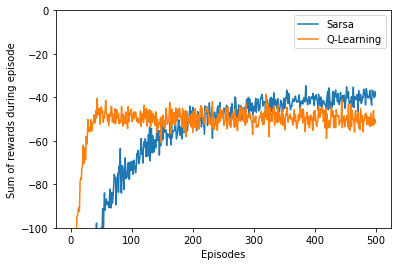

Sarsa Optimal Policy:
['L', 'R', 'R', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['L', 'R', 'D', 'R', 'R', 'R', 'R', 'L', 'R', 'R', 'D', 'D']
['R', 'R', 'R', 'D', 'R', 'R', 'R', 'D', 'R', 'R', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


In [6]:
figure_6_4()